In [18]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import h5py
import sys
import os

In [19]:
# Defin root directory
root = "."
pathogen_code = "mtuberculosis"

# Get models to evaluate
datasets = sorted(os.listdir(os.path.join(root, "..", "output", pathogen_code, "models")))
datasets = [i for i in datasets if "pkl" in i]
assays = set([i.split("_")[0] for i in datasets])

print(f"Number of datasets: {len(datasets)}")
print(f"Number of assays: {len(assays)}")

# Load descriptors
with h5py.File(os.path.join(root, "..", "output", pathogen_code, "descriptors.h5"), "r") as f:
    SMILES = f['SMILES'][:]
    X_Morgan = f['X_Morgan'][:]
    ### add here rdkit descriptors

# Define dict mapping smiles to morgan fingerprints
SMILES_TO_MORGAN = {
    smiles.decode("utf-8"): fp
    for (chembl_id, smiles), fp in zip(SMILES, X_Morgan)}

Number of datasets: 85
Number of assays: 35


In [25]:
RESULTS = {}

# For each model
for dataset in tqdm(datasets):

    # Load model
    results = []
    loaded_model = pickle.load(open(os.path.join(root, "..", "output", pathogen_code, "models", dataset), 'rb'))

    for model_to_compare in datasets:

        # If model
        if dataset == model_to_compare:

            # Load internal CV
            file = os.path.join(root, "..", "output", pathogen_code, "models", dataset.replace('.pkl', '.csv'))
            aurocs = np.array(open(file, "r").readlines()[0].split(","), dtype=float)
            RESULTS[(dataset, model_to_compare)] = np.mean(aurocs)

        # else
        else:

            # Load dataset
            data = pd.read_csv(os.path.join(root, "..", "output", pathogen_code, "datasets", model_to_compare.replace('.pkl', '.csv.gz')))
            X = data['canonical_smiles'].astype(str).tolist()
            X = np.array([SMILES_TO_MORGAN[smi] for smi in X])
            Y = data['bin'].astype(np.int8).to_numpy()

            # Predict
            Y_pred = loaded_model.predict_proba(X)[:, 1]

            # Calculate AUROC
            auroc = roc_auc_score(Y, Y_pred)
            RESULTS[(dataset, model_to_compare)] = auroc

100%|██████████| 85/85 [08:58<00:00,  6.33s/it]


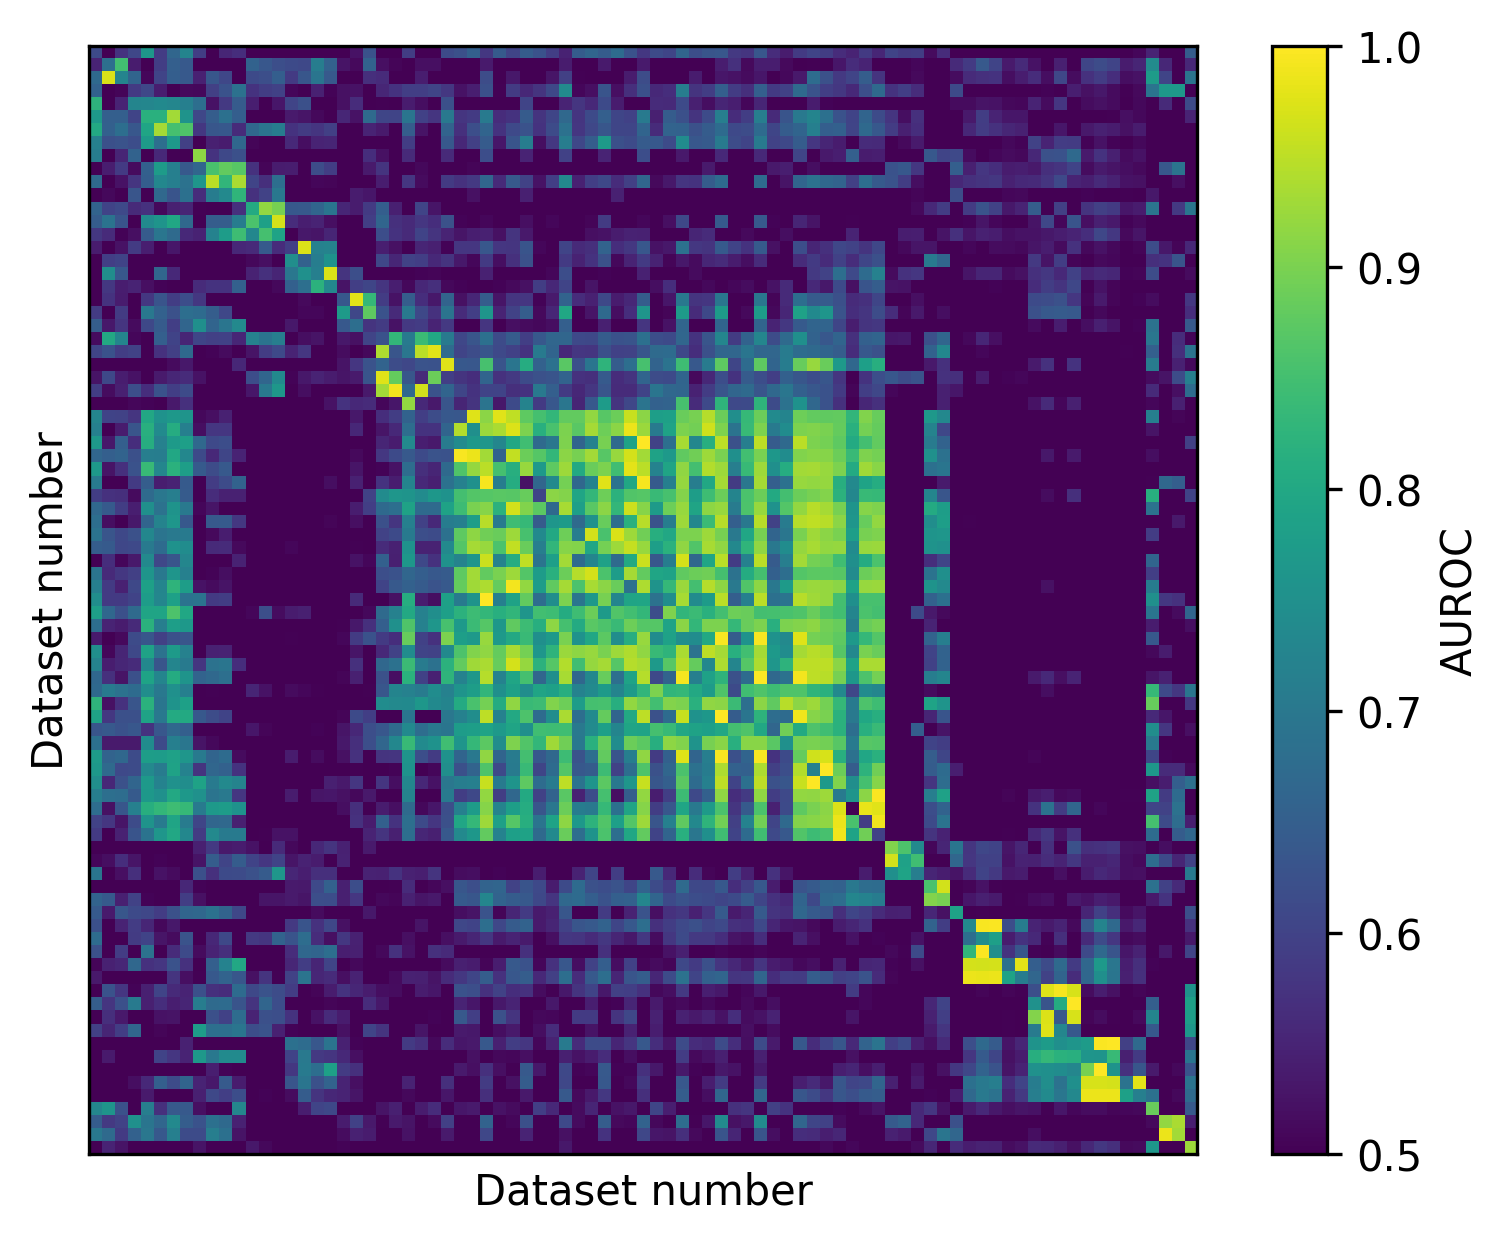

In [28]:
plt.imshow([[RESULTS[(dataset1, dataset2)] for dataset2 in datasets] for dataset1 in datasets], cmap='viridis', vmin=0.5, vmax=1)
plt.colorbar(label='AUROC')
plt.xticks([])
plt.yticks([])
plt.xlabel(('Dataset number'))
plt.ylabel(('Dataset number'))
plt.show()

'CHEMBL1049617_MIC_umol.L-1'

In [ ]:
datasets[0].split("_")[:3]

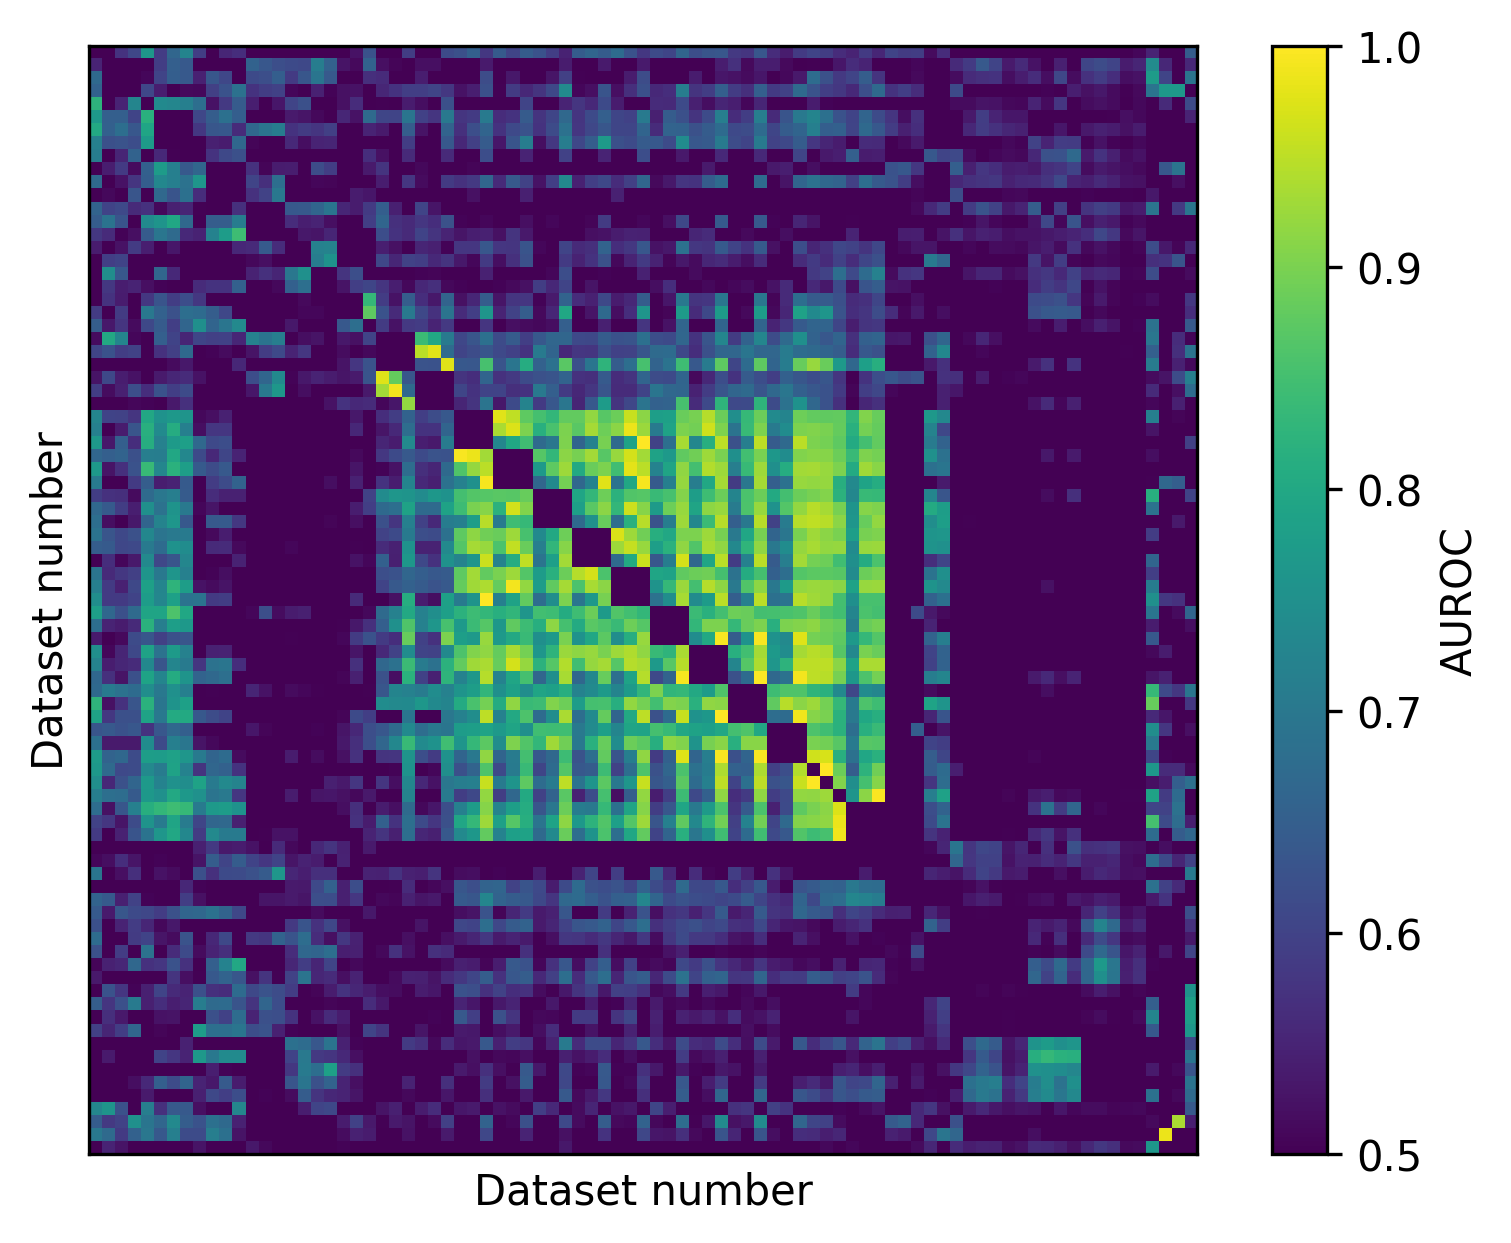

In [37]:
plt.imshow([[RESULTS[(dataset1, dataset2)] if "_".join(dataset1.split("_")[:3]) != "_".join(dataset2.split("_")[:3]) else 0 for dataset2 in datasets] for dataset1 in datasets], cmap='viridis', vmin=0.5, vmax=1)
plt.colorbar(label='AUROC')
plt.xticks([])
plt.yticks([])
plt.xlabel(('Dataset number'))
plt.ylabel(('Dataset number'))
plt.show()